In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import imageio
import os
import multiprocess as mp
from scipy.optimize import curve_fit

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
t_max = 5000
dt = .01
lam = 0.1931833275037836
N = 50

In [3]:
def init(N):
    r0 = np.zeros([N, 3])
    for i in range(N):
        r0[i] = np.array([i+1, 0, 0])
    
    p0 = np.zeros([N, 3])
    p0[0] = np.array([1/2., 0, 0])
    p0[-1] = -p0[0]
    
    return r0, p0

In [4]:
r0, p0 = init(N=N)

In [5]:
r, p, t = a.BABAB_Ndim(r0, p0, t_max, dt, f.chain_force, lam)

100%|██████████| 499999/499999 [04:29<00:00, 1853.22it/s]


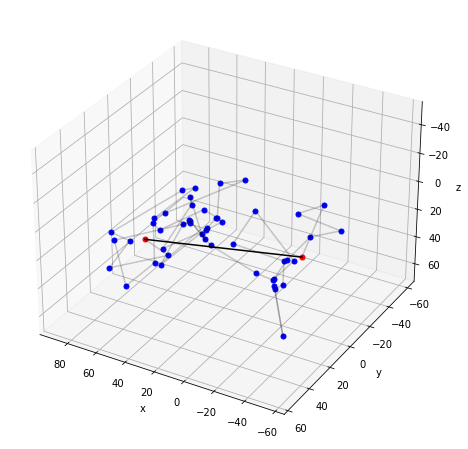

In [34]:
xlim = (r[:,:,0].max(), r[:,:,0].min())
ylim = (r[:,:,1].max(), r[:,:,1].min())
zlim = (r[:,:,2].max(), r[:,:,2].min())
files = []
for i in range(len(t)):
    
    if i%7843==0:
        plt.clf()
        fig = plt.figure(figsize=(12,8));
        ax = fig.add_subplot(111, projection='3d')
        for p_i, p in enumerate(r[i]):
            if p_i==0:
                ax.plot(p[0], p[1], p[2], color='red', linestyle='', marker='o', markersize=5)
            elif p_i == N-1:
                ax.plot(p[0], p[1], p[2], color='red', linestyle='', marker='o', markersize=5)
            else:
                ax.plot(p[0], p[1], p[2], color='blue', linestyle='', marker='o', markersize=5)
        
        bonds = np.stack((r[i][:-1], r[i][1:]), axis=1)
        end2end = np.vstack((r[i][-1], r[i][0]))
        
        for b in bonds:
            ax.plot(b[:,0], b[:,1], b[:,2], linestyle='-', color='black', alpha=0.2)
        ax.plot(end2end[:,0], end2end[:,1], end2end[:,2], linestyle='-', color='black')
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        
        filename = f'./figures/frame_{int(i/7843)}.png'
        plt.savefig(filename)
        files.append(filename)
        
        plt.draw()
        IPython.display.clear_output(wait=True)
        IPython.display.display(fig)
    plt.close()
IPython.display.clear_output(wait=True)

In [35]:
with imageio.get_writer('./figures/3d_trajectory.gif', mode='I', fps=5) as writer:
    for file in files:
        image = imageio.imread(file)
        os.remove(file)
        writer.append_data(image)

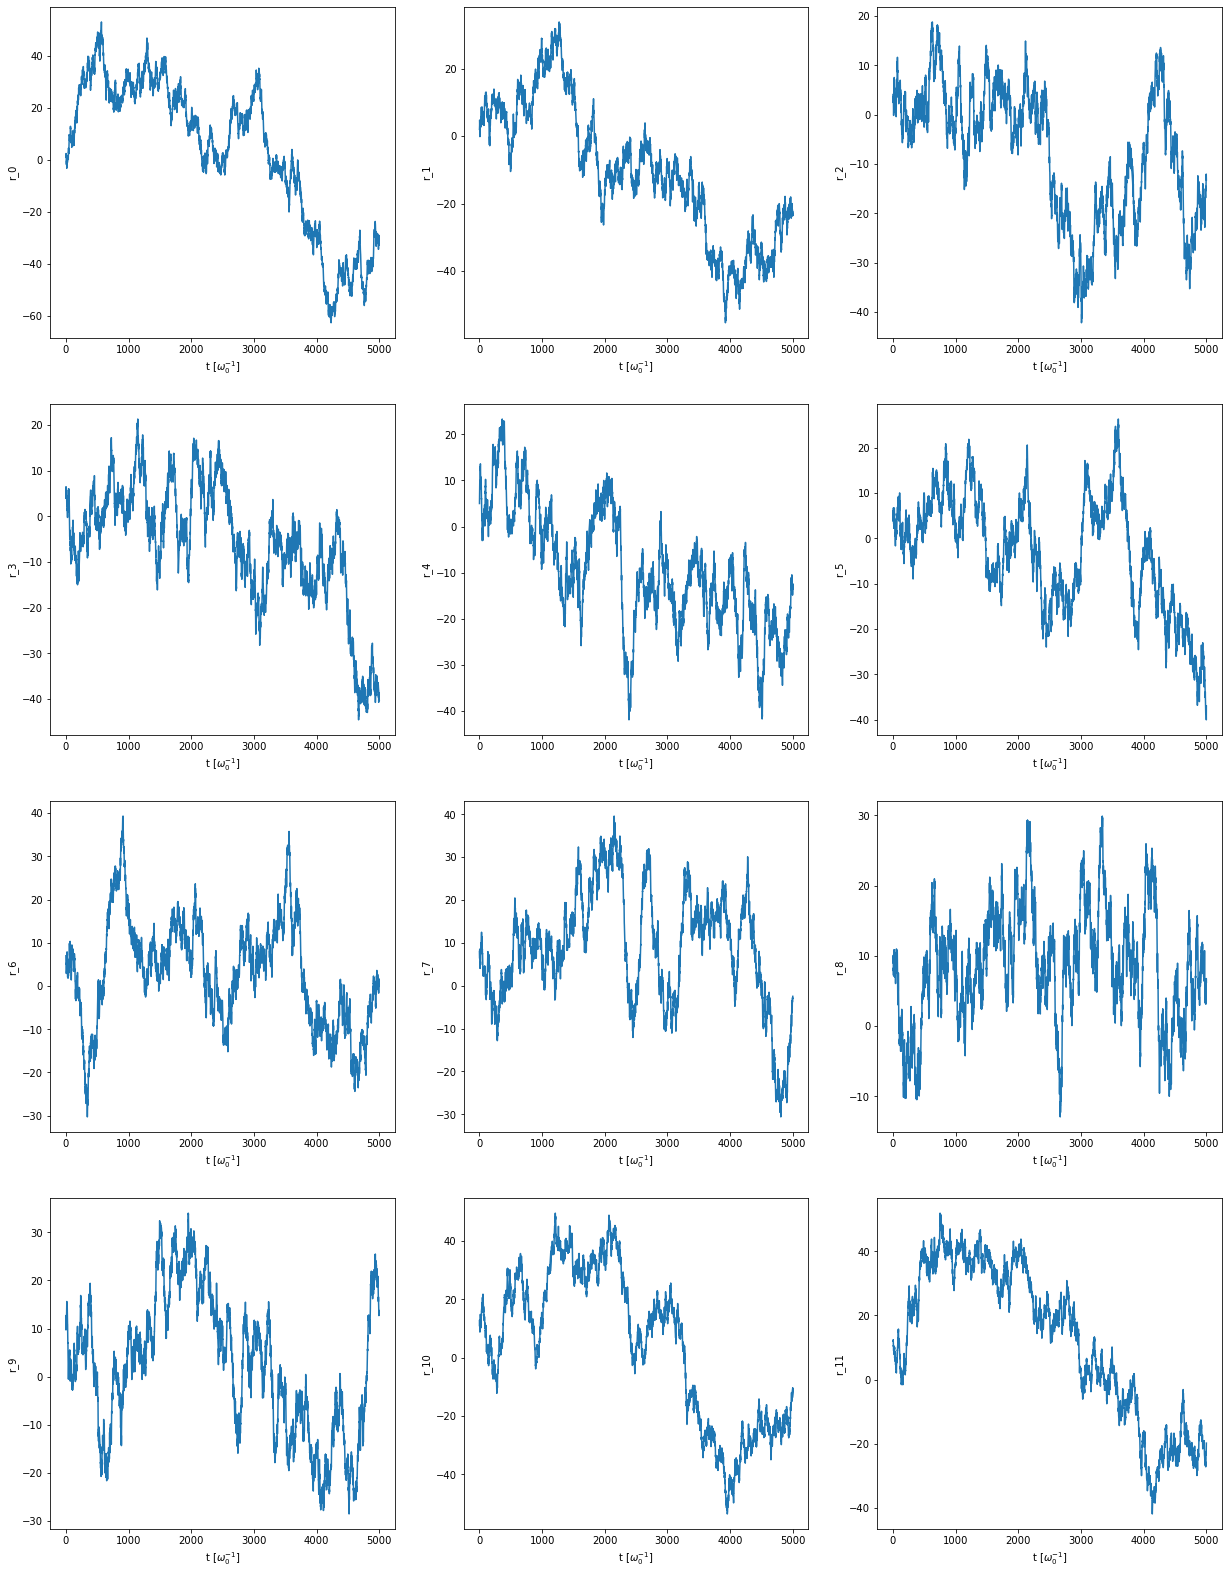

In [8]:
cols = int(np.floor(np.sqrt(10)))
rows = int(np.ceil(10 / cols))

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*7, rows*7))
i = 0
for row in range(rows):
    for col in range(cols):
        if i+1 >= r.shape[1]:
            axes[row, col].axis('off')
            continue
        
        r_i = r[:, i, 0]
        axes[row, col].plot(t, r_i)
        axes[row, col].set_xlabel(r't $[\omega_0^{-1}]$')
        axes[row, col].set_ylabel(f'r_{i}')
        
        i += 1

In [9]:
def radius_of_gyration(r, m):
    
    M = m.sum()
    
    r_cm = (m*r).sum(axis=0) / M
    
    Rg2 = np.linalg.norm(np.sqrt(m) * (r - r_cm))**2 / M
    
    return np.sqrt(Rg2)

In [10]:
def end2end_distance(r):
    return np.linalg.norm(r[-1] - r[0])

In [11]:
m = np.ones([N, 1])
R_g = np.zeros(len(t))
for i in tqdm(range(len(t))):
    R_g_i = radius_of_gyration(r[i], m)
    R_g[i] = R_g_i

100%|██████████| 500000/500000 [00:08<00:00, 56535.66it/s]


In [12]:
R_e = np.zeros(len(t))
for i in tqdm(range(len(t))):
    R_e_i = end2end_distance(r[i])
    R_e[i] = R_e_i

100%|██████████| 500000/500000 [00:02<00:00, 220155.59it/s]


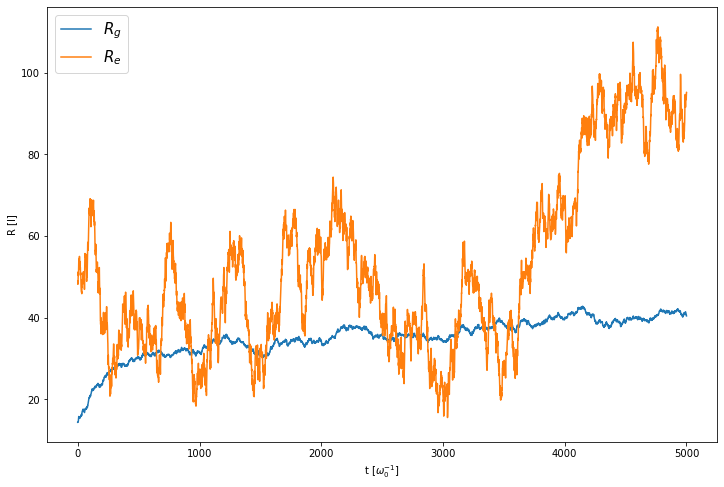

In [13]:
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(t, R_g, label=r'$R_g$')
ax1.plot(t, R_e, label=r'$R_e$')
ax1.set_xlabel(r't $[\omega_0^{-1}]$')
ax1.set_ylabel('R [l]')
plt.legend(prop={'size': 15})
plt.show()

In [14]:
def harmonic_chain_potential(r, k=1):
    return .5 * k * np.linalg.norm(r[1:] - r[:-1])**2

In [15]:
V = np.zeros(len(t))
for i in tqdm(range(len(t))):
    V_i = harmonic_chain_potential(r[i])
    V[i] = V_i

100%|██████████| 500000/500000 [00:02<00:00, 186531.17it/s]


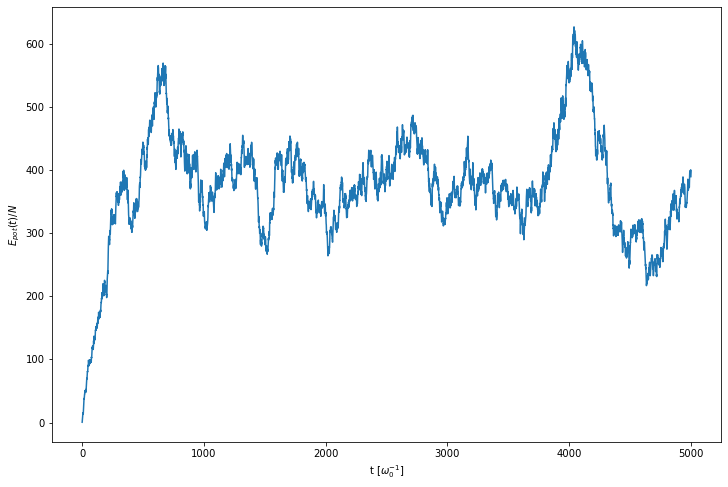

In [16]:
fig2, ax2 = plt.subplots(figsize=(12,8))
ax2.plot(t, V/N)
ax2.set_xlabel(r't $[\omega_0^{-1}]$')
ax2.set_ylabel(r'$E_{pot}(t)/N$')
plt.show()

## b)

time span needed for the relaxation: t=1000 $\omega_0^{-1}$

In [17]:
(R_g[np.where(t>1000)]**2).mean()

1367.006779426655

In [18]:
(R_e[np.where(t>1000)]**2).mean()

3621.8180084021906

In [19]:
V[np.where(t>1000)].mean() / N

379.628638812848

In [20]:
def sim_different_seeds(seed):
    np.random.seed(seed)
    N = 50
    r0, p0 = init(N=N)
    r, p, t = a.BABAB_Ndim(r0, p0, t_max, dt, f.chain_force, lam)
    
    m = np.ones([N, 1])
    R_g = np.zeros(len(t))
    for i in tqdm(range(len(t))):
        R_g_i = radius_of_gyration(r[i], m)
        R_g[i] = R_g_i
        
    R_e = np.zeros(len(t))
    for i in tqdm(range(len(t))):
        R_e_i = end2end_distance(r[i])
        R_e[i] = R_e_i
        
    V = np.zeros(len(t))
    for i in tqdm(range(len(t))):
        V_i = harmonic_chain_potential(r[i])
        V[i] = V_i
    
    R_g_avg = (R_g[np.where(t>1000)]**2).mean()
    R_e_avg = (R_e[np.where(t>1000)]**2).mean()
    V_avgs = V[np.where(t>1000)].mean() / N
    
    return [R_g_avg, R_e_avg, V_avgs]

In [21]:
seeds = [23, 453, 234, 12, 78]

mp.freeze_support()
pool_a = mp.Pool(mp.cpu_count())
results_seeds = pool_a.map(sim_different_seeds, [seed for seed in seeds])
pool_a.close()

100%|██████████| 500000/500000 [00:03<00:00, 162188.44it/s]


In [36]:
results_seeds = np.asarray(results_seeds)

In [42]:
results_seeds

array([[1578.58424939, 6278.79943192,  385.5056843 ],
       [1468.64697254, 6623.32692333,  379.99019759],
       [1514.20172074, 5249.22315449,  379.69798269],
       [1686.81083865, 4375.05021239,  416.00956087],
       [1632.3514795 , 7034.58686411,  381.78232667]])

In [39]:
print(np.mean(results_seeds[:,0]), np.std(results_seeds[:,0]))

1576.1190521625963 78.49183206801315


In [40]:
print(np.mean(results_seeds[:,1]), np.std(results_seeds[:,1]))

5912.197317247958 969.7645780784213


In [41]:
print(np.mean(results_seeds[:,2]), np.std(results_seeds[:,2]))

388.597150424527 13.861558754083196


## c)

In [23]:
def sim_different_N(N):
    np.random.seed(42)
    r0, p0 = init(N=N)
    dt = .1
    r, p, t = a.BABAB_Ndim(r0, p0, t_max, dt, f.chain_force, lam)
    
    m = np.ones([N, 1])
    R_g = np.zeros(len(t))
    for i in tqdm(range(len(t))):
        R_g_i = radius_of_gyration(r[i], m)
        R_g[i] = R_g_i
    
    R_g_avg = (R_g[np.where(t>1000)]**2).mean()
    
    return R_g_avg

In [24]:
NN = [10, 20, 50, 100, 250, 500]

mp.freeze_support()
pool_b = mp.Pool(mp.cpu_count())
results_N = pool_b.map(sim_different_N, [N for N in NN])
pool_b.close()

100%|██████████| 50000/50000 [00:01<00:00, 30184.96it/s]


In [43]:
results_N

[426.53021953136744,
 595.4873864512042,
 1492.6216727205056,
 3745.563365473743,
 8666.42520533515,
 24717.195839349763]

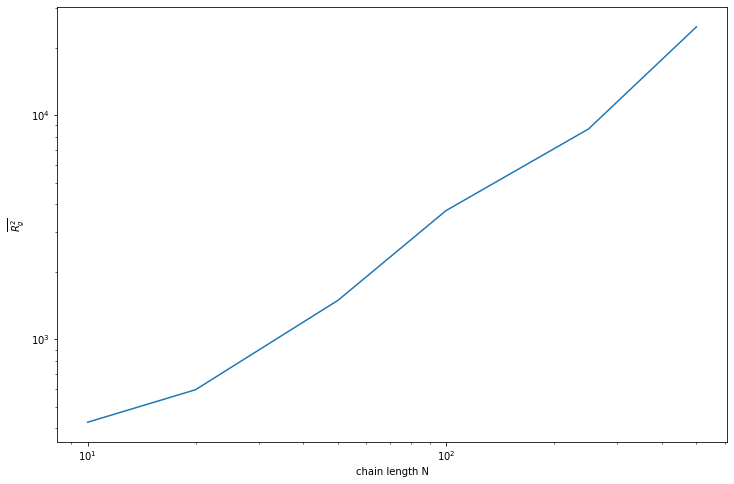

In [49]:
fig3, ax3 = plt.subplots(figsize=(12,8))
ax3.plot(NN, results_N)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('chain length N')
ax3.set_ylabel(r'$\overline{R_g^2}$')
plt.show()

In [27]:
def linear_func(x, alpha, offset):
    return x*alpha + offset

In [28]:
popt, pcov = curve_fit(linear_func, np.log(NN), np.log(results_N))
print(popt[0])

1.0504722650770917


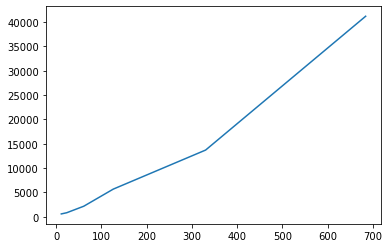

In [51]:
plt.plot(NN**popt[0], results_N**popt[0])